# Can we guess football results based on the odds of the bookmakers?

**This notebook is complementary to the article published in Medium "Can we guess football results based on the odds of the bookmakers?".**

Author: Alberto Czapka, 2022

_This project is under MIT license._

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import catboost
from catboost import Pool
from catboost import CatBoostClassifier

# Dataset

## Downloading the dataset

In [2]:
# Downloading from www.football-data.co.uk the last 20 years of Spanish First Division.

df_full_dataset = pd.DataFrame()

for i in range(2, 22):
    if i < 9:
        year = f'0{i}0{i + 1}'
    elif i == 9:
        year = f'0{i}{i + 1}'
    else:
        year = f'{i}{i + 1}'
    print(f"\tDownloading season {year}")
    df_read = pd.read_csv(f'https://www.football-data.co.uk/mmz4281/{year}/SP1.csv', on_bad_lines='skip')

    try:
        df_read['Date'] = pd.to_datetime(df_read['Date'], format="%d/%m/%y")
    except ValueError:
        df_read['Date'] = pd.to_datetime(df_read['Date'], format="%d/%m/%Y")
    df_full_dataset = pd.concat([df_full_dataset, df_read])

df_full_dataset.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,2002-08-31,Santander,Valladolid,0,1,A,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP1,2002-09-01,La Coruna,Betis,2,4,A,1,3,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SP1,2002-09-01,Mallorca,Valencia,0,2,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP1,2002-09-01,Recreativo,Malaga,2,3,A,2,1,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparing the dataset

Only bookmakers with data in most of the period will be considered.

It turns out they are:
* B365: Bet365
* IW: Interwetten
* WH: William Hill

In [3]:
# Total number of matches.

len(df_full_dataset)

7488

In [4]:
# Keep only columns with almost no missing data.

df = df_full_dataset[df_full_dataset.columns[df_full_dataset.isna().mean() < 0.02]].copy()
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365D,B365A,IWH,IWD,IWA,WHH,WHD,WHA
0,SP1,2002-08-31,Santander,Valladolid,0,1,A,0,0,D,1.909,3.25,3.40,2.10,3.0,3.1,2.00,3.1,3.30
1,SP1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1,1,D,1.500,3.40,6.00,1.55,3.5,4.8,1.53,3.4,5.50
2,SP1,2002-09-01,La Coruna,Betis,2,4,A,1,3,A,1.500,3.40,6.00,1.50,3.7,5.0,1.53,3.4,5.50
3,SP1,2002-09-01,Mallorca,Valencia,0,2,A,0,1,A,2.875,3.00,2.25,2.50,3.0,2.5,2.62,3.1,2.37
4,SP1,2002-09-01,Recreativo,Malaga,2,3,A,2,1,H,2.500,3.10,2.50,2.30,3.0,2.7,2.30,3.1,2.75


**Relevant columns explained:**
- **FTHG, FTAG**: Full time home/away goals.
- **FTR**: Full time result ("H" for home, "D" for draw and "A" for away).
- **HTHG, HTAG**: Half time home/away goals.
- **HTR**: Half time result.
- **B365H, B365D, B365A**: Bet365 bookmaker odds home/draw/away.
- **IWH, IWD, IWA**: Interwetten bookmaker odds home/draw/away.
- **WHH, WHD, WHA**: Willian Hill bookmaker odds home/draw/away.

Keep in mind that "odds" are the inverse of the probabilist prediction.

In [5]:
# Categorical predictions for each of the selected bookmakers.

all_predictions = []

for row in df.iterrows():
    match_predictions = []

    for bookhouse in ['B365', 'IW', 'WH']:
        if row[1][bookhouse + 'H'] < min(row[1][bookhouse + 'D'], row[1][bookhouse + 'A']):
            predicted_result = 'H'
        elif row[1][bookhouse + 'D'] < min(row[1][bookhouse + 'H'], row[1][bookhouse + 'A']):
            predicted_result = 'D'
        elif row[1][bookhouse + 'A'] < min(row[1][bookhouse + 'H'], row[1][bookhouse + 'D']):
            predicted_result = 'A'
        else:
            predicted_result = np.nan

        match_predictions.append(predicted_result)
    all_predictions.append(match_predictions)

df = pd.concat([df.reset_index(), pd.DataFrame(data=all_predictions, columns=['B365R', 'IWR', 'WHR'])], axis=1)
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A', 'B365R', 'IWH', 'IWD', 'IWA',
         'IWR', 'WHH', 'WHD', 'WHA', 'WHR']]
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,B365R,IWH,IWD,IWA,IWR,WHH,WHD,WHA,WHR
0,2002-08-31,Santander,Valladolid,0,1,A,1.909,3.25,3.40,H,2.10,3.0,3.1,H,2.00,3.1,3.30,H
1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1.500,3.40,6.00,H,1.55,3.5,4.8,H,1.53,3.4,5.50,H
2,2002-09-01,La Coruna,Betis,2,4,A,1.500,3.40,6.00,H,1.50,3.7,5.0,H,1.53,3.4,5.50,H
3,2002-09-01,Mallorca,Valencia,0,2,A,2.875,3.00,2.25,A,2.50,3.0,2.5,NaN,2.62,3.1,2.37,A
4,2002-09-01,Recreativo,Malaga,2,3,A,2.500,3.10,2.50,NaN,2.30,3.0,2.7,H,2.30,3.1,2.75,H


In [6]:
df.isna().mean()

Date        0.000000
HomeTeam    0.000000
AwayTeam    0.000000
FTHG        0.000000
FTAG        0.000000
FTR         0.000000
B365H       0.000801
B365D       0.000801
B365A       0.000801
B365R       0.012420
IWH         0.001736
IWD         0.001736
IWA         0.001736
IWR         0.036325
WHH         0.013622
WHD         0.013622
WHA         0.013622
WHR         0.033520
dtype: float64

In [7]:
# Dropping the few rows with missing values.

df = df.dropna().copy()

# How often do the home and away teams win?

In [8]:
# How many home wins, away wins and draws are there in the dataset?

df['FTR'].value_counts() / len(df)

H    0.476456
A    0.276514
D    0.247030
Name: FTR, dtype: float64

[Text(0.5, 1.0, 'Cumulative histogram of "full time home goals"')]

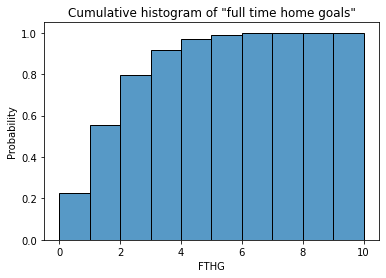

In [9]:
# Histogram of full time home goals.

sns.histplot(data=df, x='FTHG', binwidth=1, stat='probability', cumulative=True).set(title='Cumulative histogram of "full time home goals"')

[Text(0.5, 1.0, 'Cumulative histogram of "full time away goals"')]

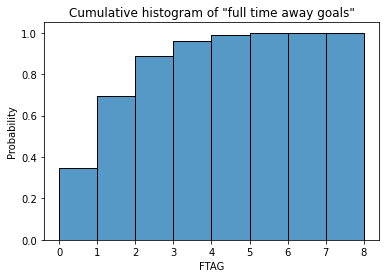

In [10]:
# Histogram of full time away goals.

sns.histplot(data=df, x='FTAG', binwidth=1, stat='probability', cumulative=True).set(title='Cumulative histogram of "full time away goals"')

[Text(0.5, 1.0, 'Correlation between full time home and away goals')]

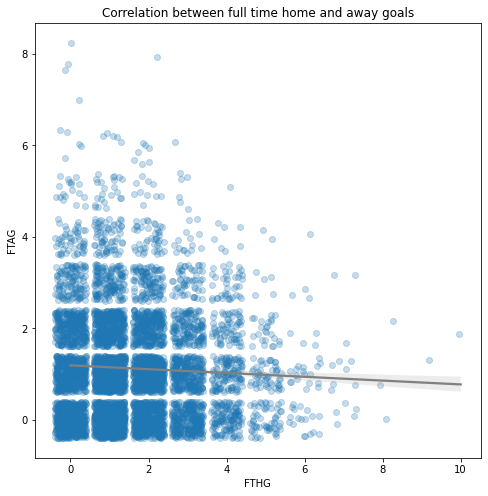

In [11]:
# Correlation between home and away goals.

plt.figure(figsize=(8,8))
sns.regplot(
    x='FTHG', 
    y='FTAG', 
    data=df, 
    order=1, 
    scatter_kws=dict(alpha=0.25), 
    line_kws=dict(color='gray'),
    x_jitter=0.4,
    y_jitter=0.4,
).set(title='Correlation between full time home and away goals')

# Are the odds of different bookmakers similar?

In [12]:
# Checking when the three bookmakers give the same prediction and when one of them (Bet365) is true.

df['is_bookmaker_R_equal'] = ((df['B365R']==df['IWR']) & (df['B365R']==df['WHR']))
df['is_B365_R_true'] = (df['B365R']==df['FTR'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,B365R,IWH,IWD,IWA,IWR,WHH,WHD,WHA,WHR,is_bookmaker_R_equal,is_B365_R_true
0,2002-08-31,Santander,Valladolid,0,1,A,1.909,3.25,3.400,H,2.10,3.0,3.1,H,2.00,3.1,3.3,H,True,False
1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1.500,3.40,6.000,H,1.55,3.5,4.8,H,1.53,3.4,5.5,H,True,False
2,2002-09-01,La Coruna,Betis,2,4,A,1.500,3.40,6.000,H,1.50,3.7,5.0,H,1.53,3.4,5.5,H,True,False
5,2002-09-01,Sevilla,Celta,0,1,A,2.375,3.10,2.625,H,2.40,3.0,2.6,H,2.25,3.1,2.8,H,True,False
6,2002-09-01,Sociedad,Ath Bilbao,4,2,H,2.200,3.00,3.000,H,2.10,3.0,3.1,H,2.25,3.1,2.8,H,True,True


In [13]:
# On average, their categorical predictions are about the same. The accuracy is around 54 %.

df[['is_bookmaker_R_equal', 'is_B365_R_true']].mean()

is_bookmaker_R_equal    0.991985
is_B365_R_true          0.541577
dtype: float64

In [14]:
# Correlation between the odds of the bookmakers.

for result in ['H', 'D', 'A']:
    print(df[['IW'+result, 'WH'+result, 'B365'+result]].corr())

            IWH       WHH     B365H
IWH    1.000000  0.979254  0.979067
WHH    0.979254  1.000000  0.988512
B365H  0.979067  0.988512  1.000000
            IWD       WHD     B365D
IWD    1.000000  0.957810  0.959007
WHD    0.957810  1.000000  0.970319
B365D  0.959007  0.970319  1.000000
            IWA       WHA     B365A
IWA    1.000000  0.959140  0.963513
WHA    0.959140  1.000000  0.971238
B365A  0.963513  0.971238  1.000000


[Text(0.5, 1.0, 'Histogram of all the odds of Bet365')]

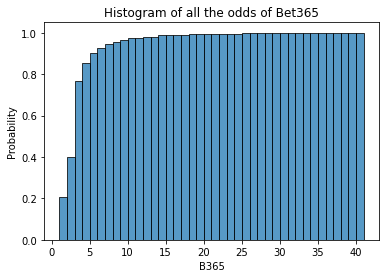

In [15]:
# Histogram of all the odds of Bet365.

all_odds_interwetten = np.concatenate((df['IWH'].values, df['IWD'].values, df['IWA'].values))
all_odds_willian_hill = np.concatenate((df['WHH'].values, df['WHD'].values, df['WHA'].values))
all_odds_bet365 = np.concatenate((df['B365H'].values, df['B365D'].values, df['B365A'].values))
df_all_odds = pd.DataFrame(data=np.array([all_odds_interwetten, all_odds_willian_hill, all_odds_bet365]).T, columns=['IW', 'WH', 'B365'])

sns.histplot(data=df_all_odds, x='B365', binwidth=1, stat='probability', cumulative=True).set(title='Histogram of all the odds of Bet365')

array([[<AxesSubplot:xlabel='IW', ylabel='IW'>,
        <AxesSubplot:xlabel='WH', ylabel='IW'>,
        <AxesSubplot:xlabel='B365', ylabel='IW'>],
       [<AxesSubplot:xlabel='IW', ylabel='WH'>,
        <AxesSubplot:xlabel='WH', ylabel='WH'>,
        <AxesSubplot:xlabel='B365', ylabel='WH'>],
       [<AxesSubplot:xlabel='IW', ylabel='B365'>,
        <AxesSubplot:xlabel='WH', ylabel='B365'>,
        <AxesSubplot:xlabel='B365', ylabel='B365'>]], dtype=object)

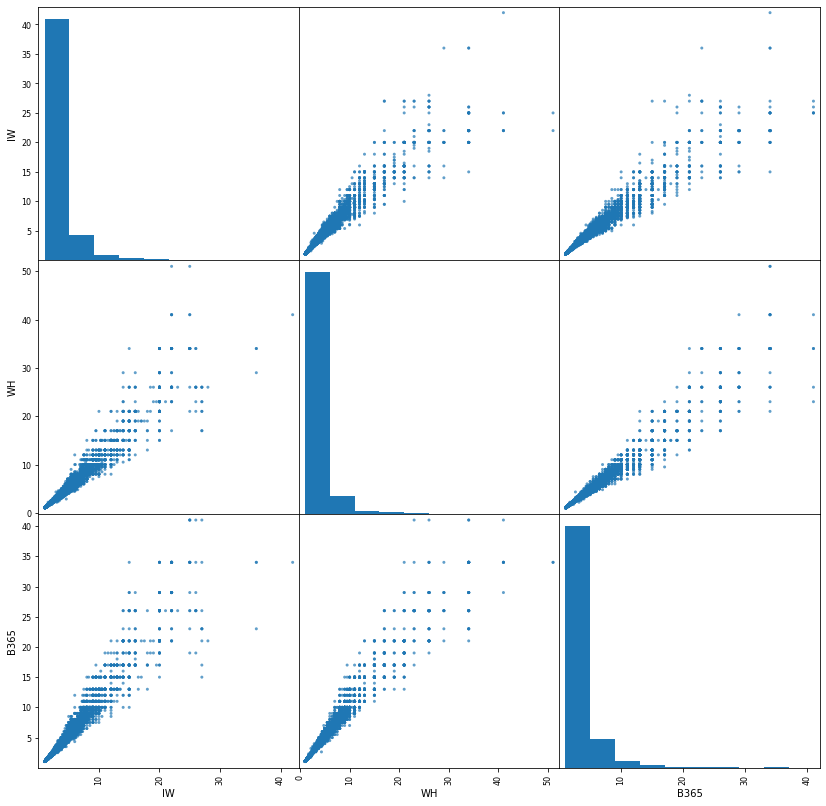

In [16]:
# Correlation plot between the odds of the bookmakers.

pd.plotting.scatter_matrix(df_all_odds, alpha=.7, figsize=(14, 14))

array([[<AxesSubplot:xlabel='IW', ylabel='IW'>,
        <AxesSubplot:xlabel='WH', ylabel='IW'>,
        <AxesSubplot:xlabel='B365', ylabel='IW'>],
       [<AxesSubplot:xlabel='IW', ylabel='WH'>,
        <AxesSubplot:xlabel='WH', ylabel='WH'>,
        <AxesSubplot:xlabel='B365', ylabel='WH'>],
       [<AxesSubplot:xlabel='IW', ylabel='B365'>,
        <AxesSubplot:xlabel='WH', ylabel='B365'>,
        <AxesSubplot:xlabel='B365', ylabel='B365'>]], dtype=object)

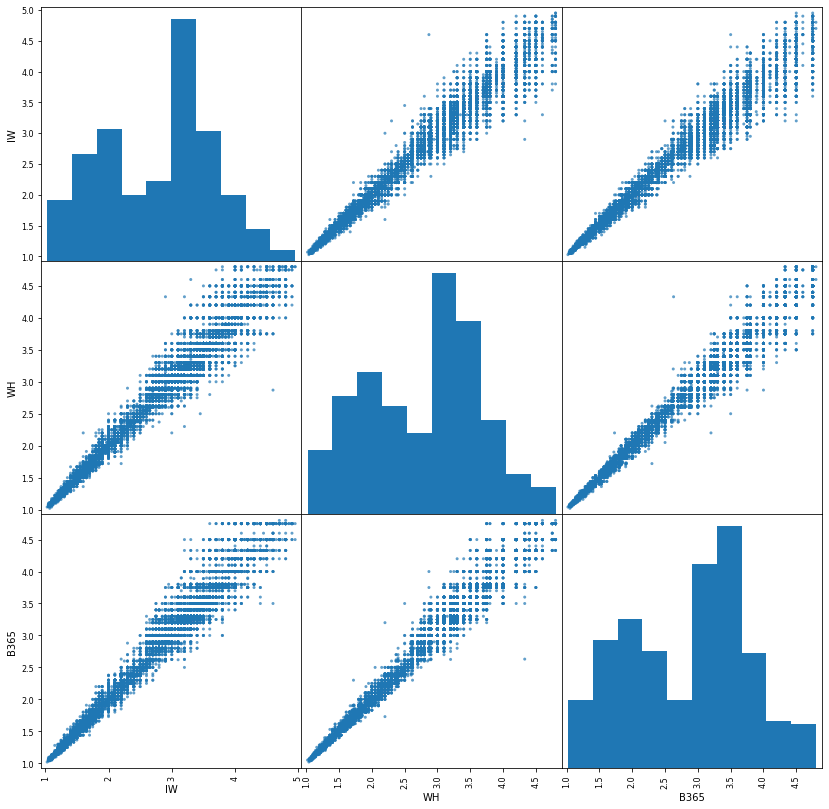

In [17]:
# Correlation plot between the odds of the bookmakers (without extremely high values, only odds below 5).

pd.plotting.scatter_matrix(df_all_odds[df_all_odds.max(axis=1) < 5], alpha=.7, figsize=(14, 14))

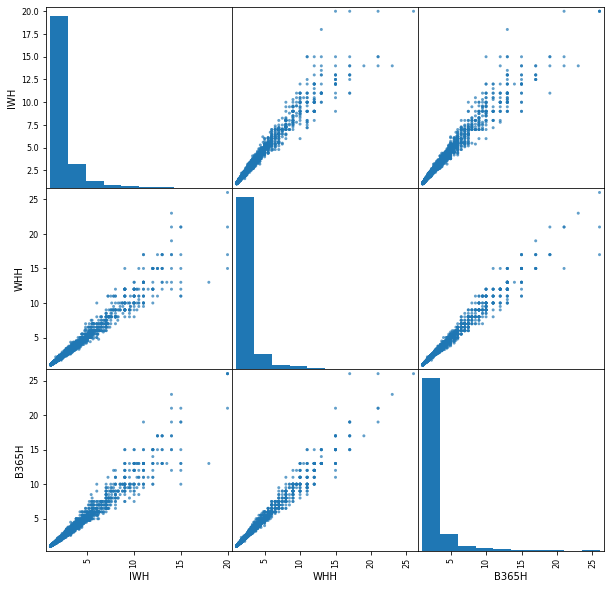

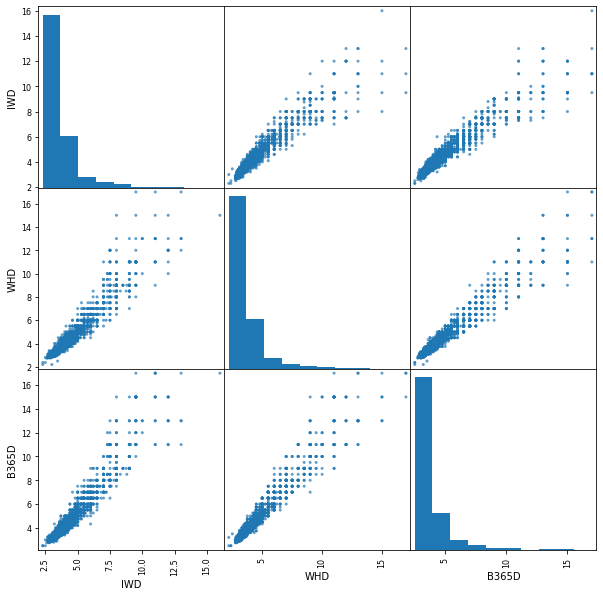

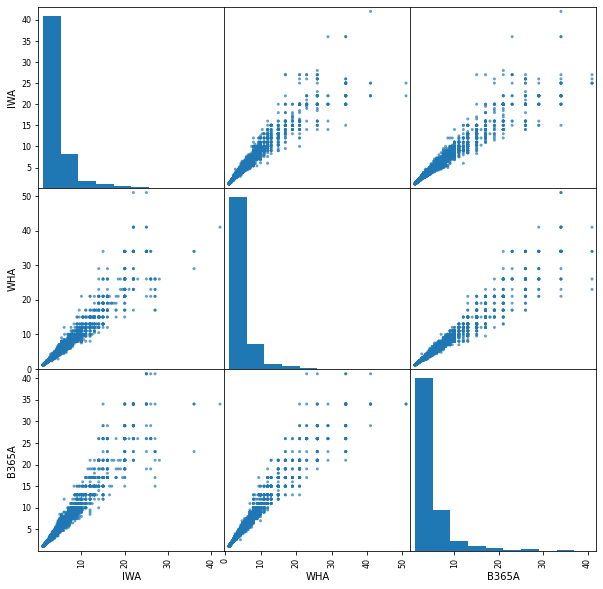

In [18]:
# Correlation plot between the odds of the bookmakers (for each result).

for result in ['H', 'D', 'A']:
    pd.plotting.scatter_matrix(df[['IW' + result, 'WH' + result, 'B365' + result]], alpha=.7, figsize=(10, 10))

# How accurate are the predictions of the bookmakers?

In [19]:
# Average accuracy.

df['is_B365_R_true'].mean()

0.5415772148275368

Text(0.5, 15.0, 'Predicted label')

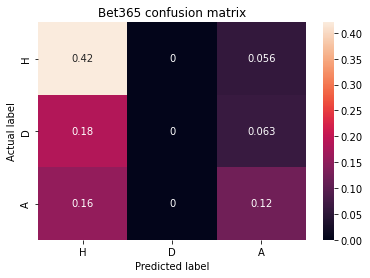

In [20]:
# Confusion matrix.

bookmaker_confusion_matrix = confusion_matrix(y_true=df['FTR'], y_pred=df['B365R'], labels=['H', 'D', 'A'], normalize='all') 
bookmaker_confusion_matrix = pd.DataFrame(data=bookmaker_confusion_matrix, columns=['H', 'D', 'A'], index=['H', 'D', 'A'])

sns.heatmap(bookmaker_confusion_matrix, annot=True)
plt.title('Bet365 confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Have the predictions of the bookmakers changed over time?

In [21]:
# A season has around 380 matches: rolling average of two seasons.

df['is_B365_R_true_average'] = df['is_B365_R_true'].rolling(380 * 2).mean()

(12437.1, 19452.9, 0.0, 1.0)

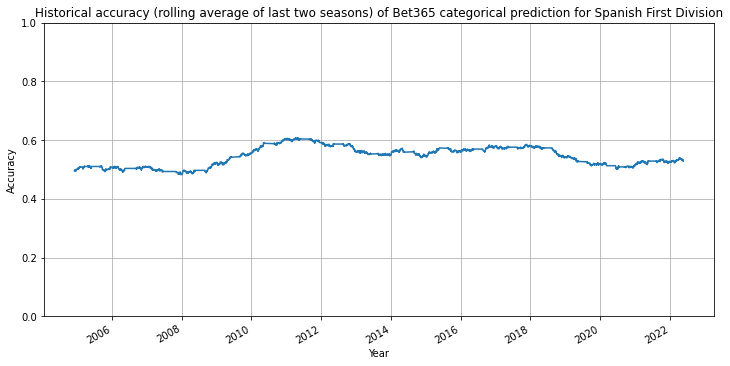

In [22]:
# Accuracy historical plot.

df.set_index('Date')['is_B365_R_true_average'].plot(
    figsize=(12, 6), 
    title='Historical accuracy (rolling average of last two seasons) of Bet365 categorical prediction for Spanish First Division', 
    xlabel ="Year", 
    ylabel="Accuracy", 
    grid=True,
).axis([None, None, 0, 1])

(12437.1, 19452.9, 0.0, 1.2)

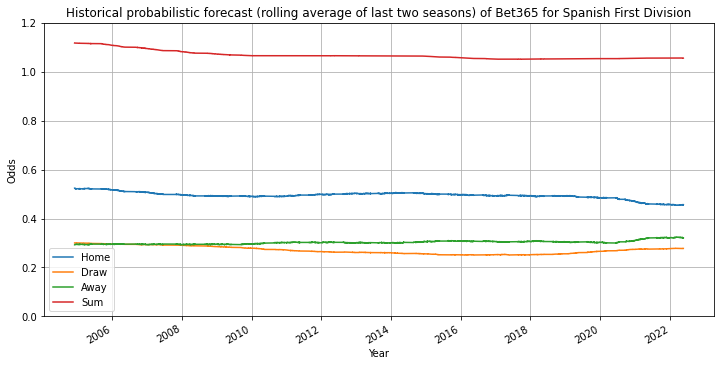

In [23]:
# Odds historical plot.

df_plot = df.copy()

df_plot['Home'] = 1 / df_plot['B365H']
df_plot['Draw'] = 1 / df_plot['B365D']
df_plot['Away'] = 1 / df_plot['B365A']
df_plot['Sum'] = df_plot['Home'] + df_plot['Draw'] + df_plot['Away']

df_plot['Home'] = df_plot['Home'].rolling(380 * 2).mean()
df_plot['Draw'] = df_plot['Draw'].rolling(380 * 2).mean()
df_plot['Away'] = df_plot['Away'].rolling(380 * 2).mean()
df_plot['Sum'] = df_plot['Sum'].rolling(380 * 2).mean()

df_plot.set_index('Date')[['Home', 'Draw', 'Away', 'Sum']].plot(
    figsize=(12, 6),
    title='Historical probabilistic forecast (rolling average of last two seasons) of Bet365 for Spanish First Division',
    xlabel="Year",
    ylabel="Odds",
    grid=True,
).axis([None, None, 0, 1.2])

# Are the odds of the bookmakers properly estimated?

In [24]:
# This function will calculate if the following strategies and models are profitable.

def calculate_roi_and_accuracy(observations, predictions, odds_home, odds_draw, odds_away, money_each_bet=100):
    """Calculates the return over investment (ROI) and accuracy of applying a certain betting sequence"""

    profits = 0
    investments = 0
    true_counter = 0

    for i, match in enumerate(observations):
        investments += money_each_bet

        earned_money_this_match = 0
        if observations[i] == predictions[i]:
            true_counter += 1
            if observations[i] == 'H':
                earned_money_this_match = money_each_bet * odds_home[i]
            elif observations[i] == 'D':
                earned_money_this_match = money_each_bet * odds_draw[i]
            elif observations[i] == 'A':
                earned_money_this_match = money_each_bet * odds_away[i]
        profits = profits + earned_money_this_match - money_each_bet

    return_over_investment = profits / investments * 100
    return_over_investment = round(return_over_investment, 1)

    accuracy = true_counter / len(observations) * 100
    accuracy = round(accuracy, 1)

    return return_over_investment, accuracy

## Naive strategy

In [25]:
# Let's try some really simple strategies and see what happens.

def naive_strategy_bet(strategy, odds_home, odds_draw, odds_away):
    """Generates one bet for one particular match according to a naive strategy"""

    bet = None
    if strategy == 'always_home':
        bet = 'H'
    elif strategy == 'always_draw':
        bet = 'D'
    elif strategy == 'always_away':
        bet = 'A'
    elif strategy == 'highest_odds':
        if odds_home >= odds_draw and odds_home >= odds_away:
            bet = 'H'
        elif odds_draw >= odds_home and odds_draw >= odds_away:
            bet = 'D'
        else:
            bet = 'A'
    elif strategy == 'intermediate_odds':
        if odds_away >= odds_home >= odds_draw or odds_draw >= odds_home >= odds_away:
            bet = 'H'
        elif odds_home >= odds_draw >= odds_away or odds_away >= odds_draw >= odds_home:
            bet = 'D'
        else:
            bet = 'A'
    elif strategy == 'lowest_odds':
        if odds_home <= odds_draw and odds_home <= odds_away:
            bet = 'H'
        elif odds_draw <= odds_home and odds_draw <= odds_away:
            bet = 'D'
        else:
            bet = 'A'
    elif strategy == 'random':
        bet = np.random.choice(['H', 'D', 'A'])
    return bet


for strategy in ['random', 'always_home', 'always_draw', 'always_away', 'highest_odds', 'intermediate_odds',
                 'lowest_odds']:
    bets = []
    results = []
    for match in df.itertuples():
        odds_home = match.B365H
        odds_draw = match.B365D
        odds_away = match.B365A
        result = match.FTR

        bet = naive_strategy_bet(strategy, odds_home, odds_draw, odds_away)
        bets.append(bet)
        results.append(result)

    roi, accuracy = calculate_roi_and_accuracy(
        observations=results,
        predictions=bets,
        odds_home=df['B365H'].values,
        odds_draw=df['B365D'].values,
        odds_away=df['B365A'].values,
    )
    print(f"For the {strategy} strategy we have and accuracy of {accuracy} % and an average return on investment of {roi} %.")

For the random strategy we have and accuracy of 32.6 % and an average return on investment of -11.0 %.
For the always_home strategy we have and accuracy of 47.6 % and an average return on investment of -3.5 %.
For the always_draw strategy we have and accuracy of 24.7 % and an average return on investment of -10.4 %.
For the always_away strategy we have and accuracy of 27.7 % and an average return on investment of -10.2 %.
For the highest_odds strategy we have and accuracy of 21.0 % and an average return on investment of -7.6 %.
For the intermediate_odds strategy we have and accuracy of 24.7 % and an average return on investment of -12.5 %.
For the lowest_odds strategy we have and accuracy of 54.2 % and an average return on investment of -4.3 %.


## Catboost classifier (multi-class)

In [26]:
# Trying catboost, only using odds as predictors.

labels = df[['FTR']]
features = df[['B365H', 'B365D', 'B365A']]
categorical_features = []

features_train, features_validation, labels_train, labels_validation = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=0,
)
train_pool = Pool(
    data=features_train,
    label=labels_train,
)
validation_pool = Pool(
    data=features_validation,
    label=labels_validation,
)
model = CatBoostClassifier()
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.111757
0:	learn: 1.0711280	test: 1.0689616	best: 1.0689616 (0)	total: 50.2ms	remaining: 50.2s
100:	learn: 0.9472549	test: 0.9497160	best: 0.9466631 (35)	total: 242ms	remaining: 2.15s
200:	learn: 0.9216196	test: 0.9569083	best: 0.9466631 (35)	total: 424ms	remaining: 1.69s
300:	learn: 0.9029416	test: 0.9647291	best: 0.9466631 (35)	total: 617ms	remaining: 1.43s
400:	learn: 0.8885782	test: 0.9708253	best: 0.9466631 (35)	total: 811ms	remaining: 1.21s
500:	learn: 0.8772738	test: 0.9772202	best: 0.9466631 (35)	total: 1.15s	remaining: 1.15s
600:	learn: 0.8664973	test: 0.9825974	best: 0.9466631 (35)	total: 1.33s	remaining: 882ms
700:	learn: 0.8581124	test: 0.9880815	best: 0.9466631 (35)	total: 1.52s	remaining: 647ms
800:	learn: 0.8499592	test: 0.9935510	best: 0.9466631 (35)	total: 1.69s	remaining: 419ms
900:	learn: 0.8432234	test: 0.9979008	best: 0.9466631 (35)	total: 1.86s	remaining: 204ms
999:	learn: 0.8377060	test: 1.0017985	best: 0.9466631 (35)	total: 2.05s	remaining:

In [27]:
# Results on validation dataset.

roi, accuravy = calculate_roi_and_accuracy(
    observations=labels_validation.values.flatten(), 
    predictions=model.predict(validation_pool).flatten(), 
    odds_home=features_validation['B365H'].values, 
    odds_draw=features_validation['B365D'].values, 
    odds_away=features_validation['B365A'].values
)
print(f"For the catboost model (only odds as features) we have and accuracy of {accuracy} % and an average return on investment of {roi} %.")

For the catboost model (only odds as features) we have and accuracy of 54.2 % and an average return on investment of 0.8 %.


In [28]:
# # Trying catboost, using odds and team names as predictors.

labels = df[['FTR']]
features = df[['B365H', 'B365D', 'B365A', 'HomeTeam', 'AwayTeam']]
categorical_features = ['HomeTeam', 'AwayTeam']

features_train, features_validation, labels_train, labels_validation = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=0,
)
train_pool = Pool(
    data=features_train,
    label=labels_train,
    cat_features=categorical_features
)
validation_pool = Pool(
    data=features_validation,
    label=labels_validation,
    cat_features=categorical_features
)
model = CatBoostClassifier()
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.111757
0:	learn: 1.0717944	test: 1.0695536	best: 1.0695536 (0)	total: 8.39ms	remaining: 8.38s
100:	learn: 0.9112574	test: 0.9545848	best: 0.9508544 (40)	total: 361ms	remaining: 3.22s
200:	learn: 0.8577014	test: 0.9603402	best: 0.9508544 (40)	total: 715ms	remaining: 2.84s
300:	learn: 0.8072144	test: 0.9679441	best: 0.9508544 (40)	total: 1.08s	remaining: 2.5s
400:	learn: 0.7613137	test: 0.9732735	best: 0.9508544 (40)	total: 1.47s	remaining: 2.2s
500:	learn: 0.7206631	test: 0.9830285	best: 0.9508544 (40)	total: 1.87s	remaining: 1.86s
600:	learn: 0.6832518	test: 0.9892606	best: 0.9508544 (40)	total: 2.29s	remaining: 1.52s
700:	learn: 0.6522652	test: 0.9942057	best: 0.9508544 (40)	total: 2.68s	remaining: 1.14s
800:	learn: 0.6198229	test: 1.0004058	best: 0.9508544 (40)	total: 3.07s	remaining: 762ms
900:	learn: 0.5928399	test: 1.0046612	best: 0.9508544 (40)	total: 3.43s	remaining: 377ms
999:	learn: 0.5655213	test: 1.0102574	best: 0.9508544 (40)	total: 3.82s	remaining: 0

In [29]:
# Results on validation dataset.

roi, accuravy = calculate_roi_and_accuracy(
    observations=labels_validation.values.flatten(), 
    predictions=model.predict(validation_pool).flatten(), 
    odds_home=features_validation['B365H'].values, 
    odds_draw=features_validation['B365D'].values, 
    odds_away=features_validation['B365A'].values
)
print(f"For the catboost model (odds and team names as features) we have and accuracy of {accuracy} % and an average return on investment of {roi} %.")

For the catboost model (odds and team names as features) we have and accuracy of 54.2 % and an average return on investment of -0.5 %.


## Logistic regression (binary classification of draws)

In [30]:
# Let's try binary classifying if a match is a draw or not.

df['FTR_is_draw'] = 0
df.loc[df['FTR'] == 'D', 'FTR_is_draw'] = 1

In [31]:
# Logistic regression.

labels = df[['FTR', 'FTR_is_draw']]
features = df[['B365H', 'B365D', 'B365A']]

features_train, features_validation, labels_train, labels_validation = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=0,
)
clf = LogisticRegression(random_state=0).fit(
    X=features_train,
    y=labels_train[['FTR_is_draw']].values.flatten(),
)

In [32]:
# Results on validation dataset.

accuracy = round(clf.score(X=features_validation, y=labels_validation[['FTR_is_draw']].values.flatten()) * 100, 2)
print(f"The accuracy on validation dataset is {accuracy} % but this is because the regression predicted {clf.predict(features_validation).sum()} draws in total.")

The accuracy on validation dataset is 77.47 % but this is because the regression predicted 0 draws in total.


In [33]:
predictions = clf.predict(features_validation)
predictions = np.array(['D' if prediction==1 else None for prediction in predictions])
observations = labels_validation[['FTR']].values.flatten()


roi, accuracy = calculate_roi_and_accuracy(
    observations=observations, 
    predictions=predictions, 
    odds_home=features_validation['B365H'].values, 
    odds_draw=features_validation['B365D'].values, 
    odds_away=features_validation['B365A'].values
)
print(f"For the logistic regression (binary classification of draws) we have and accuracy of {accuracy} % and an average return on investment of {roi} %.")

For the logistic regression (binary classification of draws) we have and accuracy of 0.0 % and an average return on investment of -100.0 %.
